In [27]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_google_vertexai import ChatVertexAI
MODEL_ID="gemini-1.5-flash-001"
PROJECT_ID="genai-exchange-hackathon"
REGION="asia-south1"

llm2 = ChatVertexAI(model_name=MODEL_ID)

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-70b-versatile")

In [4]:
import os
import vertexai
from langchain_google_vertexai import VertexAIEmbeddings
vertexai.init(
        project=os.environ.get("VERTEX_PROJECT_ID"),
        location=os.environ.get("VERTEX_PROJECT_LOCATION")
        )
embeddings = VertexAIEmbeddings(model_name="text-embedding-004", location=REGION, project=PROJECT_ID)

In [5]:
import os
from langchain_qdrant import QdrantVectorStore

def get_vector_retriever():
    QDRANT_URL=os.environ.get("QDRANT_URL")
    QDRANT_API_KEY=os.environ.get("QDRANT_API_KEY")
    vectorstore = QdrantVectorStore.from_existing_collection(
        collection_name="dsa_notes",
        embedding=embeddings,
        url=QDRANT_URL,
        api_key=QDRANT_API_KEY,
    )
    return vectorstore.as_retriever(k=2)

retriever = get_vector_retriever()

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [7]:
from langchain_community.document_loaders import WikipediaLoader

In [8]:
from langgraph.graph import MessagesState
from operator import add
# from langgraph.graph.message import add_messages
from typing import Annotated

class State(MessagesState):
    summary: str
    context: str

In [9]:
from langchain_core.messages import SystemMessage, HumanMessage

simple_solver_prompt = """You are helping with solving a student's questions about data structures and algorithms.

These can be questions about definitions, help with debugging code or hard leetcode style problems to solve.

Think carefully before answering any question. Explain your reasoning.

Do not hallucinate. Do not make up facts. If you don't know how to answer a problem, just say so.

Be concise."""

def simple_solver(state: State):
    
    messages = [SystemMessage(content=simple_solver_prompt)]
    
    # get summary if it exists
    summary = state.get("summary", "")
    
    # if there is summary, we add it to prompt
    if summary:
        
        # add summary to system message
        summary_message = f"Summary of conversation earlier: {summary}"
        
        # append summary to any newer message
        messages += [HumanMessage(content=summary_message)]
    
    messages += state["messages"]
    
    response = llm.invoke(messages)
    # NEED TO PREVENT CONTEXT FROM BALLOONING if I change it to list and want to persist that
    return {"context": response.content}

In [73]:


socratic_prompt = """You are a tutor trying to help a student gain a very strong understanding of a concept/problem. 

You are helping them with a problem and want to help them understand the concepts by figuring out the solution themselves with only nudges in the right direction.

You have the solution above but the student has never seen it.

If the student wants to learn about a new concept: use the solution to provide the necessary context. Then, based on that ask the student a question that requires them to apply the concept in code to help enhance their understanding.

If the question is a problem to solve: based on the solution to the question, use the socratic method to guide the student towards the answer.

Provide hints or prompt the student to think of the next step. If the student seems to be really stuggling with a concept, provide a larger hint. Always take a code-first approach when explaining, giving examples, or solving a problem."""

def socratic(state: State):
    messages = [SystemMessage(content=state["context"] + socratic_prompt)]
    summary = state.get("summary", "")
    if summary:
        summary_message = f"Summary of your conversation with the student: {summary}"
        messages += [HumanMessage(content=summary_message)]
    messages += state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}

In [74]:
from langchain_core.messages import RemoveMessage

def summarize_conversation(state: State):
    summary = state.get("summary", "")
    
    if summary:
        summary_message = (
            f"This is the summary of the conversation to date: {summary}\n\n"
            "Be concise and extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"
    
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [75]:
from langgraph.graph import END

def should_summarize(state: State):
    """Return whether to summarize depending on length of messages"""
    messages = state["messages"]
    
    if len(messages) > 6:
        return "summarize"
    return END

In [76]:
from langgraph.errors import NodeInterrupt
from langchain_core.messages import AIMessage
# Human in the loop
def give_answer(state: State):
    """Ask the student if they want a complete solution"""
    messages = state['messages']
    if len(messages) > 2:
        state["messages"] += [AIMessage("Would you like me to provide you the complete answer? Please reply as yes or no.")]
        raise NodeInterrupt(f"Recent chat longer than 6 messages")

In [77]:
def route_to_answer(state: State):
    if len(state['messages']) > 2:
        message = state['messages'][-1]
        if 'yes' in str(message).lower():
            state["messages"] += [HumanMessage("yes")] + [HumanMessage(state['context'])]
            return 'summarize'
    else:
        return 'socratic'

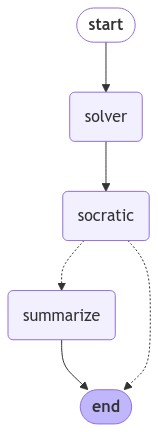

In [78]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(State)
workflow.add_node("solver", simple_solver)
workflow.add_node("socratic", socratic)
workflow.add_node("summarize", summarize_conversation)
# workflow.add_node("interrupt", give_answer)

workflow.add_edge(START, "solver")
workflow.add_edge("solver", "socratic")
# workflow.add_edge("solver", "interrupt")
# workflow.add_conditional_edges("interrupt", route_to_answer, {"summarize": "summarize", "socratic": "socratic"})
workflow.add_conditional_edges("socratic", should_summarize, {"summarize": "summarize", END: END})
workflow.add_edge("summarize", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [79]:
config = {"configurable": {"thread_id": "6"}}

input_message = HumanMessage(content="what is hashing?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()
    
input_message = HumanMessage(content="I'm not sure")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
    
input_message = HumanMessage(content="I think I'm starting to get it but I need more help")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hashing is a fundamental concept in computer science, but don't worry if you're not familiar with it yet. Let's break it down step by step.

Imagine you have a large library with millions of books, and you want to find a specific book quickly. One way to do this is by using a catalog system where each book is assigned a unique identifier or "hash" based on its title, author, or other characteristics.

In computer science, a hash is a fixed-size value that represents a larger piece of data, like a string or an integer. This hash value is generated using a hash function, which takes the input data and maps it to a unique hash value.

Here's an example to illustrate this concept. Let's say we have a simple hash function that takes a string as input and returns a hash value based on the length of the string.

```python
def simple_hash(input_string):
    return len(input_string)

print(simple_hash("hello"))  #

In [15]:
graph.get_state(config).values.get("summary","")

''

In [36]:
config = {"configurable": {"thread_id": "6"}}
input_message = HumanMessage(content="I think the databases have a key associated with each item that can be indexed very quickly.")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Would you like me to provide you the complete answer? Please reply as yes or no.


In [37]:
graph.get_state(config).next

('interrupt',)

In [38]:
graph.get_state(config).tasks

(PregelTask(id='04f3cc1c-d4a0-c3c5-c41f-4fdfeac8f9c3', name='interrupt', error=None, interrupts=(Interrupt(value='Recent chat longer than 6 messages', when='during'),), state=None),)

In [39]:
graph.update_state(
    config,
    {"messages": "yes"},
)

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7b188-064c-6666-8007-8aea05227951'}}

In [58]:
for event in graph.stream(None, config, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='What is hashing?', id='8c23a2f7-86bc-4a1c-a8a4-e307648abdd2'), AIMessage(content="Hashing is a fundamental concept in computer science, but let's break it down step by step.\n\nTo start, can you think of a situation where you have a large amount of data, and you want to quickly identify or locate a specific piece of information within that data? Perhaps you've used a library or a database before. How do you think the library or database manages to find the specific book or piece of information you're looking for so quickly?\n\nWhat if I told you that there's a way to map a piece of information, like a string or an integer, to a unique identifier that can help us locate it more efficiently? What would you call this process, and how do you think it might work?", response_metadata={'token_usage': {'completion_tokens': 145, 'prompt_tokens': 515, 'total_tokens': 660, 'completion_time': 0.581719616, 'prompt_time': 0.139046958, 'queue_time': 0.55903782, 'to

In [49]:
graph.get_state(config).next

('interrupt',)

In [50]:
graph.update_state(config, {"messages": "no"},)

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7b484-199a-6b88-8008-d6e7871d3b09'}}

In [64]:
for event in graph.stream({"messages": [HumanMessage(content="what is pretty_print in python?")]}, config, stream_mode="updates"):
    event['socratic']['messages'].pretty_print()

KeyError: 'socratic'

In [57]:
for event in graph.stream(None, config, stream_mode="values"):
    for value in event:
        print(value)

messages
context


In [ ]:
for chunk in graph.stream({"messages": input_message}, config, stream_mode="updates"):
    chunk